In [657]:
import functools
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import collections as mc
from matplotlib.ticker import MaxNLocator

import xml.etree.ElementTree as ET
import os 
from time import time 
from math import ceil

base_path = os.getcwd()
data_path = os.path.join(base_path, 'domaci_ukol_data')
data_files = [file for file in os.listdir(data_path) if '.DS' not in file]
datasets = [os.path.join(data_path, file) for file in data_files]

In [658]:
def parse_dataset(dataset):
    tree = ET.parse(dataset)
    root = tree.getroot()

    network = {}
    requests = {}
    depo = None
    capacity = None

    for child in root:
        if child.tag == 'network':
            for item in child[0]:
                network.update({int(item.attrib['id']) : 
                                {'x' : float(item[0].text), 'y' : float(item[1].text)}})
        if child.tag == 'requests':
            for item in child:
                requests.update({int(item.attrib['node']) : float(item[0].text)})
        if child.tag == 'fleet':
            depo = int(child[0][0].text)
            capacity = float(child[0][2].text)
                       
    return network, requests, capacity, depo

def plot_route(network, route, depo, ax, colors):
    route_lines = []
    
    for i, j in zip(route, route[1:] + [route[0]]):
        route_lines.append([(network[i]['x'], network[i]['y']), (network[j]['x'], network[j]['y'])])    

    color = np.random.choice(colors)
    colors.remove(color)
    route_lc = mc.LineCollection(route_lines, colors=[color])
    ax.add_collection(route_lc)
    ax.autoscale()

def plot_routes(network, routes, depo):
    lines = []
    colors = []
    for i, v1 in enumerate(network):
        for j, v2 in enumerate(network):
            lines.append([(network[v1]['x'], network[v1]['y']), (network[v2]['x'], network[v2]['y'])])
            colors.append(pheromones[i+1][j+1])

    lc = mc.LineCollection(lines, linewidths=np.array(colors))

    plt.figure(figsize=(12, 8))
    ax = plt.gca()
    ax.add_collection(lc)
    ax.autoscale()
    
    colors = [str(item) for item in list(mcolors.CSS4_COLORS.keys())]
    
    for route in routes:
        plot_route(network, route, depo, ax, colors)
        
def parse_routes(target, depo):
    size = len(target)
    idx_list = [idx + 1 for idx, val in
                enumerate(target) if val == depo]

    res = [target[i: j] for i, j in
            zip([0] + idx_list, idx_list +
            ([size] if idx_list[-1] != size else []))]
    
    return res 

@functools.lru_cache(maxsize=None)
def distance(v1, v2):
    return np.sqrt((network[v1]['x'] - network[v2]['x'])**2+(network[v1]['y'] - network[v2]['y'])**2)

def plot_fitness(values, name):
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(range(1, len(values) + 1), values)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_xlim(0.5, len(values)+1)
    ax.set_xlabel('iteration')
    ax.set_ylabel('fitness')
    ax.set_title('Evolution of ' + name + ' fitness over iterations')
    ax.grid(True)
    plt.show()

In [659]:
def initialize_pheromone(N):
    return 0.01*np.ones(shape=(N+1,N+1))

def update_pheromone(pheromones_array, solutions, fits, Q=100, rho=0.6):
    pheromone_update = np.zeros(shape=pheromones_array.shape)
    for solution, fit in zip(solutions, fits):
        for x, y in zip(solution[0], solution[0][1:]):
            pheromone_update[x][y] += Q/fit
        pheromone_update[solution[0][-1]][solution[0][0]] += Q/fit
    
    return (1-rho)*pheromones_array + pheromone_update

def fitness(network, distance, solution, min_vehicles, depo):
    solution_distance = 0
    vehicle_count = solution[1]
    solution = solution[0]
    first = solution[0]
    for index, vertices in enumerate(zip(solution, solution[1:])):
        x, y = vertices
        solution_distance += distance(x, y)
        if y == depo:
            solution_distance += distance(solution[-1], first)
            if index+2 < len(solution):
                first = solution[index+2]
            
    fitness = solution_distance + (0.2 * (vehicle_count - min_vehicles) * solution_distance)
    return fitness, solution_distance, vehicle_count

def generate_solutions(network, pheromones, capacity, depo, requests, distance, N, alpha=1, beta=3):
    
    def compute_prob(v1, v2):
        dist = 1/distance(v1, v2)
        tau = pheromones[v1-1, v2-1]
        ret = pow(tau, alpha) * pow(dist,beta)
        return ret if ret > 0.000001 else 0.000001
    
    def filter_available(available, available_capacity, requests):
        filtered = [] 
        for item in available:
            if requests[item] < available_capacity:
                filtered.append(item)
        return filtered

    pheromones_shape = pheromones.shape[0]
 
    for i in range(N):
        vehicle_count = 1
        available_capacity = capacity
        available = [item for item in requests]
        unserved_customers = [item for item in requests]
        start = available[i]
        available_capacity -= requests[start]
        available.remove(start)
        available = filter_available(available, available_capacity, requests)
        unserved_customers.remove(start)
        solution = [start]
        
        while unserved_customers:
            probs = np.array(list(map(lambda x: compute_prob(solution[-1], x), available)))
            selected = np.random.choice(available, p=probs/sum(probs))
            solution.append(selected)
            available.remove(selected)
            unserved_customers.remove(selected)
            available_capacity -= requests[selected]
            available = filter_available(available, available_capacity, requests)
            
            if len(available) == 0 and len(unserved_customers) > 0:
                vehicle_count += 1 
                available_capacity = capacity
                available = [item for item in unserved_customers]
                solution.append(depo)
        
        solution.append(depo)
        yield solution, vehicle_count

def ant_solver(network, distance, capacity, depo, requests, min_vehicles, ants=10, max_iterations=500, alpha=1, beta=3, Q=100, rho=0.8):
    pheromones = initialize_pheromone(len(network))
    best_solution = None
    best_fitness = float('inf')
    best_solution_index = None
    fitness_history = [] 
    best_fits = [] 
    
    for i in range(max_iterations):
        solutions = list(generate_solutions(network, pheromones, capacity, depo, requests, distance, ants, alpha=alpha, beta=beta))
        fits = list(map(lambda x: fitness(network, distance, x, min_vehicles, depo)[0], solutions))
        pheromones = update_pheromone(pheromones, solutions, fits, Q=Q, rho=rho)
        
        for s, f in zip(solutions, fits):
            if f < best_fitness:
                best_fitness = f
                best_solution = s
        
        fitness_history.append(min(fits))
        best_fits.append(best_fitness)
        
#         print(f'{i+1:4}, {np.min(fits):.4f}, {np.mean(fits):.4f}, {np.max(fits):.4f}')
    return (best_solution, pheromones, fitness_history, best_fits)


Fitness: 423.51818335480164
Distance: 423.51818335480164
Vehicle count: 4
Minimum required vehicles: 4
Time: 1449.0
Routes:
[25, 26, 27, 24, 23, 22, 31, 30, 29, 28, 54, 47, 44, 43, 45, 46, 49, 48, 50, 52, 51, 53, 71, 40, 39, 38, 41, 42, 56, 55, 62, 65, 17, 4, 1]
[19, 18, 14, 3, 16, 20, 2, 13, 7, 72, 11, 5, 9, 8, 10, 6, 66, 64, 63, 60, 59, 70, 35, 1]
[32, 33, 37, 36, 34, 69, 68, 67, 57, 58, 1]
[21, 15, 12, 61, 1]


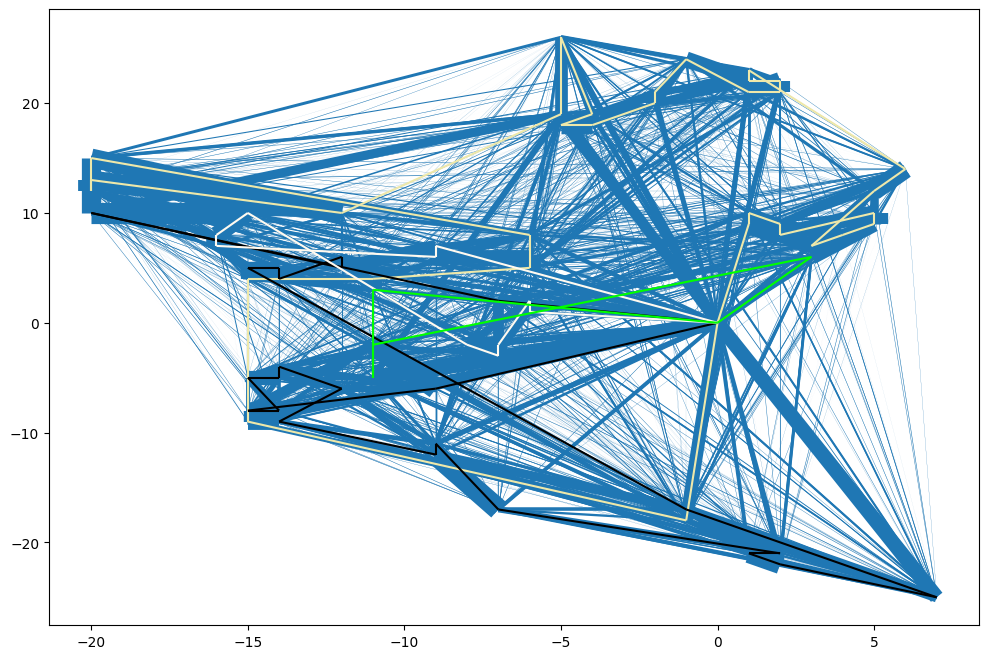

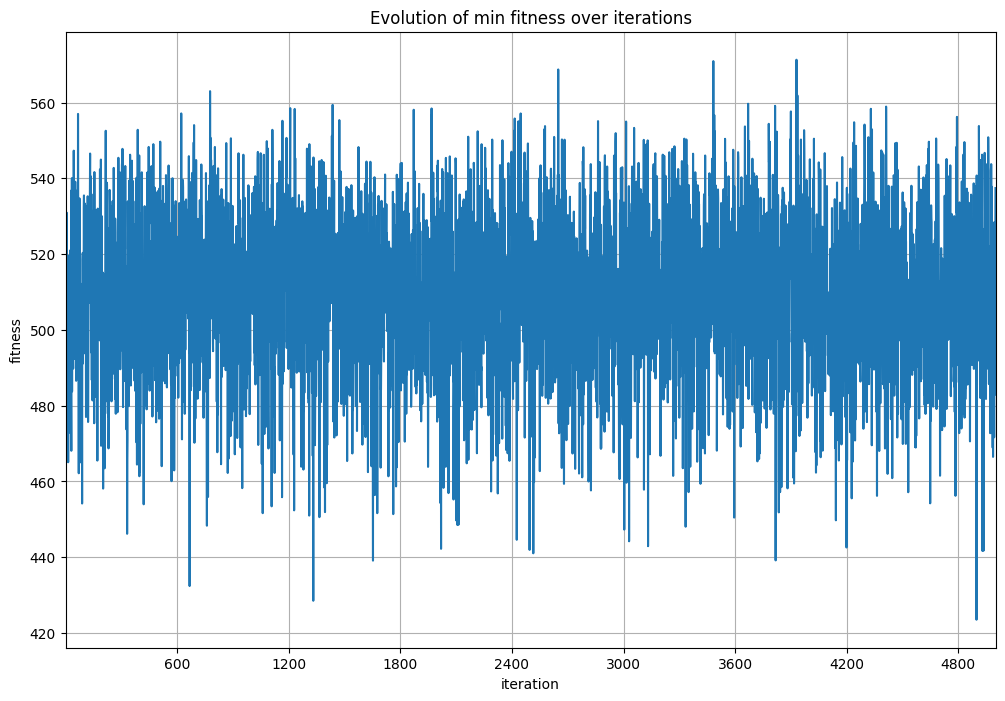

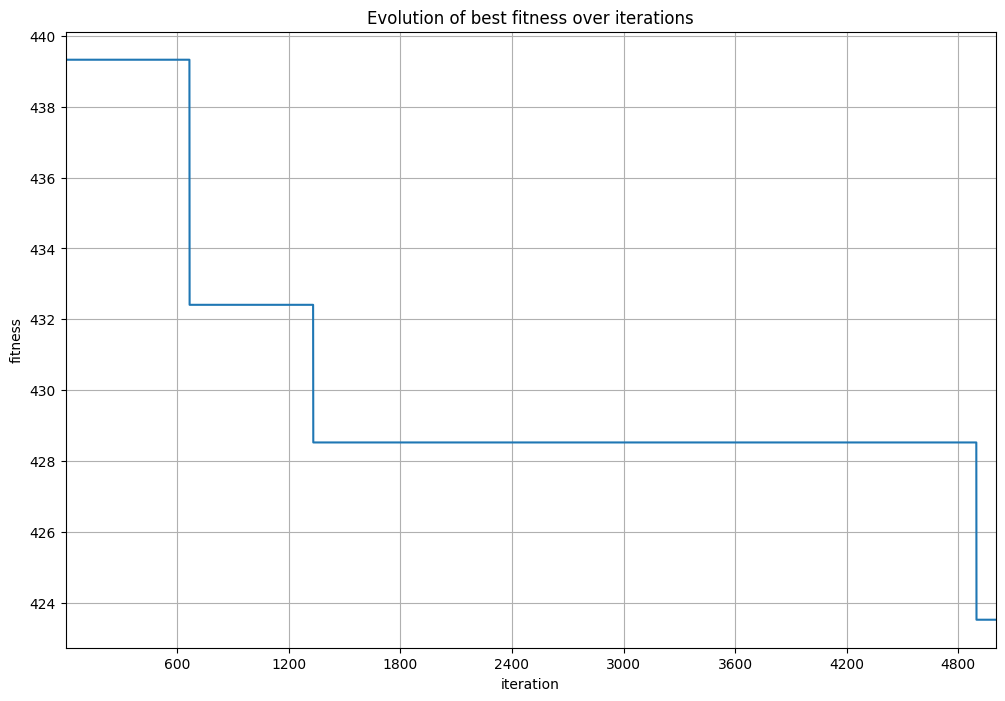

In [696]:
dataset = 0
network, requests, capacity, depo = parse_dataset(datasets[dataset])
min_vehicles = ceil(sum(requests.values()) / capacity)

alpha = 1
beta = 3
rho = 0.7
Q = 200
max_iterations = 5000

start = time()
best_solution, pheromones, fitness_history, best_fits = ant_solver(network, distance, capacity, depo, requests, min_vehicles, ants=len(network)-1, max_iterations=max_iterations, alpha=alpha, beta=beta, rho=rho, Q=Q)
end = time()
solution = best_solution
fit, dst, vehicle_count = fitness(network, distance, solution, min_vehicles, depo)
solution = solution[0]

print()
print('Fitness:', fit)
print('Distance:', dst)
print('Vehicle count:', vehicle_count)
print('Minimum required vehicles:', min_vehicles)
print('Time:', round(end - start, 1))
print('Routes:')

routes = parse_routes(solution, depo)
for route in routes:
    print(route)

plot_routes(network, routes, depo)
plot_fitness(fitness_history, 'min')    
plot_fitness(best_fits, 'best')